## Неделя 2. Вторник 
### Обучение с учителем

### Применение ансаблей моделей для задач классификации и регрессии

1. Загружаем предобработанный датасет (либо загружаем и очищаем, если не осталось сохраненной версии)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn

sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    TargetEncoder,
    FunctionTransformer,
)
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)

# models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
)
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score


# tunning hyperparamters model
import optuna

from catboost import CatBoostClassifier

import lightgbm as lgb

import xgboost as xgb

In [4]:
from sqlite3 import converters


df = pd.read_csv("./../data/heart.csv")

# Разделяем датасет на матрицу признаков и столбец target

X, y = df.drop("HeartDisease", axis=1), df["HeartDisease"]

# Делим датасеты на train и valid в соотношении 80-20

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_features = df.select_dtypes(exclude="object")
cat_features = df.select_dtypes(include="object")

my_imputer = ColumnTransformer(
    transformers=[("num_imputer", SimpleImputer(strategy="median"), ["Age"])],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
scaler_columns = ["RestingBP", "Cholesterol", "MaxHR", "Oldpeak", "Age"]
encoding_columns = list(cat_features.columns)


def float_to_int(x):
    return x.astype(int)


to_int = FunctionTransformer(float_to_int)


encode_and_scale = ColumnTransformer(
    [
        ("ordinal_enc", make_pipeline(OrdinalEncoder(), to_int), encoding_columns),
        ("scaling_num_columns", StandardScaler(), scaler_columns),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

scale_for_cb = ColumnTransformer(
    [
        ("scaling_num_columns", StandardScaler(), scaler_columns),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

preprocessor = Pipeline(
    [
        ("imputer", my_imputer),
        ("scaler_and_encoder", encode_and_scale),
    ]
)

preprocessor_for_cb = Pipeline(
    [
        ("imputer", my_imputer),
        ("scaler_and_encoder", scale_for_cb),
    ]
)
# X_train = preprocessor.fit_transform(X_train, y_train)
# X_train
# X_valid = preprocessor.transform(X_valid)

In [419]:
# X_train = X_train.loc[::, ordinal_encoding_columns].convert_dtypes()
# X_valid = X_valid.loc[::, ordinal_encoding_columns].convert_dtypes()

2. К прежним датасетам применяем ансамбли моделей: 
    - `RandomForest`
    - `Voting`
    - `Catboost`([https://catboost.ai/en/docs/concepts/python-installation](https://catboost.ai/en/docs/concepts/python-installation))
    - `LightGBM`([https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html))
    - `XGBoost` ([https://xgboost.readthedocs.io/en/latest/install.html](https://xgboost.readthedocs.io/en/latest/install.html))

#### Random Forest

In [5]:
rf_pipe = Pipeline(
    [
        ("imputer", my_imputer),
        ("scaler", encode_and_scale),
        (
            "model",
            RandomForestClassifier(n_estimators=20, random_state=42, max_depth=6),
        ),
    ]
)


rf_pipe.fit(X_train, y_train)

print(
    "RandomForest train accuracy: ", accuracy_score(y_train, rf_pipe.predict(X_train))
)
print(
    "RandomForest valid accuracy: ", accuracy_score(y_valid, rf_pipe.predict(X_valid))
)

RandomForest train accuracy:  0.9182561307901907
RandomForest valid accuracy:  0.8967391304347826


#### Voting

In [421]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=10, criterion="gini", random_state=42)
knn = KNeighborsClassifier(n_neighbors=10, p=2, weights="distance", n_jobs=4)


vc_pipe = Pipeline(
    [
        ("imputer", my_imputer),
        ("scaler_encoder", encode_and_scale),
        (
            "model",
            VotingClassifier(
                [("LogReg", lr), ("DecisionTree", dt), ("KNeighbors", knn)]
            ),
        ),
    ]
)


# voting_pipeline = Pipeline(
#     [("imputer", my_imputer), ("scaler_encoder", encode_and_scale), ("model", vc)]
# )
vc_pipe.fit(X_train, y_train)
print("voting train accuracy: ", accuracy_score(y_train, vc_pipe.predict(X_train)))
print("voting valid accuracy: ", accuracy_score(y_valid, vc_pipe.predict(X_valid)))

voting train accuracy:  0.9863760217983651
voting valid accuracy:  0.8967391304347826


#### CatBoost

In [422]:
cb = CatBoostClassifier(
    eval_metric="Accuracy",
    iterations=2000,
    random_seed=42,
    cat_features=encoding_columns,
    task_type="CPU",
    verbose=100,
)

cb_pipe = Pipeline(
    [
        ("imputer", my_imputer),
        # ("ordinal_enc", encode_and_scale),
        ("model", cb),
    ]
)

cb_pipe.fit(
    X_train,
    y_train,
)

Learning rate set to 0.004781
0:	learn: 0.8542234	total: 3.9ms	remaining: 7.8s
100:	learn: 0.8760218	total: 146ms	remaining: 2.75s
200:	learn: 0.8869210	total: 303ms	remaining: 2.71s
300:	learn: 0.8978202	total: 436ms	remaining: 2.46s
400:	learn: 0.9005450	total: 604ms	remaining: 2.41s
500:	learn: 0.9059946	total: 755ms	remaining: 2.26s
600:	learn: 0.9114441	total: 888ms	remaining: 2.07s
700:	learn: 0.9182561	total: 1.01s	remaining: 1.88s
800:	learn: 0.9223433	total: 1.14s	remaining: 1.71s
900:	learn: 0.9264305	total: 1.28s	remaining: 1.57s
1000:	learn: 0.9318801	total: 1.41s	remaining: 1.41s
1100:	learn: 0.9332425	total: 1.57s	remaining: 1.28s
1200:	learn: 0.9346049	total: 1.7s	remaining: 1.13s
1300:	learn: 0.9373297	total: 1.84s	remaining: 987ms
1400:	learn: 0.9427793	total: 2.01s	remaining: 861ms
1500:	learn: 0.9441417	total: 2.13s	remaining: 710ms
1600:	learn: 0.9468665	total: 2.29s	remaining: 572ms
1700:	learn: 0.9523161	total: 2.42s	remaining: 426ms
1800:	learn: 0.9536785	total: 

,steps,"[('imputer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [423]:
print("CatBoost train accuracy: ", accuracy_score(y_train, cb_pipe.predict(X_train)))
print("CatBoost valid accuracy: ", accuracy_score(y_valid, cb_pipe.predict(X_valid)))

CatBoost train accuracy:  0.9400544959128065
CatBoost valid accuracy:  0.8967391304347826


#### LightGBM

In [424]:
lgbm_pipe = Pipeline(
    [
        ("imputer", my_imputer),
        ("scaler_encoder", encode_and_scale),
        ("model", lgb.LGBMClassifier(n_estimators=40, random_state=42, max_depth=5)),
    ]
)

lgbm_pipe.fit(X_train, y_train)

,steps,"[('imputer', ...), ('scaler_encoder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [425]:
print("LightGBM train accuracy: ", accuracy_score(y_train, lgbm_pipe.predict(X_train)))
print("LightGBM valid accuracy: ", accuracy_score(y_valid, lgbm_pipe.predict(X_valid)))

LightGBM train accuracy:  0.9400544959128065
LightGBM valid accuracy:  0.8804347826086957


#### XGBoost

In [426]:
xgb_pipe = Pipeline(
    [
        ("imputer", my_imputer),
        ("scaler_encoder", encode_and_scale),
        (
            "model",
            xgb.XGBClassifier(n_estimators=40, random_state=42, max_depth=5, n_jobs=-1),
        ),
    ]
)
xgb_pipe.fit(X_train, y_train)

,steps,"[('imputer', ...), ('scaler_encoder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [427]:
print("XGBoost train accuracy: ", accuracy_score(y_train, xgb_pipe.predict(X_train)))
print("XGBoost valid accuracy: ", accuracy_score(y_valid, xgb_pipe.predict(X_valid)))

XGBoost train accuracy:  0.9945504087193461
XGBoost valid accuracy:  0.8804347826086957


# ❓
Какие значения по умолчанию заданы в случайном лесе для числа деревьев и их глубины?

> Число деревьев - 100, глубина деревьев - не ограничена

3. Прогоните модели через `optuna`, определяем лучшие параметры и сохраняем результат в словарь вида:
    ```python
    results = {'model_name' : best_result}
    ```

Типичные параметры для оптимизации градиентного бустинга: 
* число итераций алгоритма
* глубина деревьев
* скорость обучения (`learning_rate`). 
Чтобы попробовать оптимизировать модели, стоит обратиться к документации: разные реализации будут предлагать разные варианты параметров. 

   > Для классификации используем метрику `accuracy_score`

In [428]:
rf_pipe.named_steps

{'imputer': ColumnTransformer(remainder='passthrough',
                   transformers=[('num_imputer',
                                  SimpleImputer(strategy='median'), ['Age'])],
                   verbose_feature_names_out=False),
 'scaler': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal_enc',
                                  Pipeline(steps=[('ordinalencoder',
                                                   OrdinalEncoder()),
                                                  ('functiontransformer',
                                                   FunctionTransformer(func=<function float_to_int at 0x7410f05558a0>))]),
                                  ['Sex', 'ChestPainType', 'RestingECG',
                                   'ExerciseAngina', 'ST_Slope']),
                                 ('scaling_num_columns', StandardScaler(),
                                  ['RestingBP', 'Cholesterol', 'MaxHR',
                                   'Ol

In [429]:
X_train_preproc_rf = preprocessor.fit_transform(X_train, y_train)
X_valid_preproc_rf = preprocessor.fit(X_valid)


def objective_rf(trial):

    # Параметры самой модели
    model_params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.5, step=0.05),
        "n_estimators": trial.suggest_int("n_estimators", 10, 50, step=10),
    }

    model_rf = RandomForestClassifier(**model_params)

    # # Можно добавить выбор encoder'а
    # encoder_type_label = trial.suggest_categorical(
    #     "encoder_type", ["OneHotEnc", "TargetEnc"]
    # )
    # encoder_mapping = {
    #     "OneHotEnc": OneHotEncoder(sparse_output=False),
    #     "TargetEnc": TargetEncoder(),
    # }

    # rf_pipe.named_steps["scaler_encoder"].set_params(
    #     encoding_columns=encoder_mapping[encoder_type_label]
    # )

    # Создание сплитов для кросс-валидации
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Вычисление метрик точности с использованием кросс-валидации
    scores = cross_val_score(
        model_rf,
        X_train_preproc_rf,
        y_train,
        cv=cv,
        scoring="accuracy",
    )

    accuracy = scores.mean()

    return accuracy


study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50, n_jobs=-1)

best_params_rf = study_rf.best_params
best_value_rf = study_rf.best_value
results = {}
results["RandomForest"] = best_value_rf

print(f"Лучшие параметры: {best_params_rf}")
print(f"Лучшее значение: {best_value_rf}")
print(results)

[I 2025-08-26 19:10:00,385] A new study created in memory with name: no-name-64f17b25-cac5-4e9c-8b99-8289b593bafc
[I 2025-08-26 19:10:01,302] Trial 4 finished with value: 0.8419718572360451 and parameters: {'max_depth': 8, 'n_estimators': 10}. Best is trial 4 with value: 0.8419718572360451.
[I 2025-08-26 19:10:01,337] Trial 15 finished with value: 0.8474326716988166 and parameters: {'max_depth': 9, 'n_estimators': 10}. Best is trial 15 with value: 0.8474326716988166.
[I 2025-08-26 19:10:02,006] Trial 13 finished with value: 0.8447115832634424 and parameters: {'max_depth': 6, 'n_estimators': 20}. Best is trial 15 with value: 0.8474326716988166.
[I 2025-08-26 19:10:02,040] Trial 1 finished with value: 0.8487932159165036 and parameters: {'max_depth': 9, 'n_estimators': 20}. Best is trial 1 with value: 0.8487932159165036.
[I 2025-08-26 19:10:02,068] Trial 5 finished with value: 0.8569378436306028 and parameters: {'max_depth': 6, 'n_estimators': 20}. Best is trial 5 with value: 0.8569378436

Лучшие параметры: {'max_depth': 5, 'n_estimators': 40}
Лучшее значение: 0.8651477029167832
{'RandomForest': 0.8651477029167832}


#### Код от Любови

In [430]:
# results = {}

# # RandomForest objective


# def objective_rf(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#     }
#     model = RandomForestClassifier(**params, random_state=42)
#     cv = KFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(
#         model, X_train_preprocessed, y_train, cv=cv, scoring="accuracy"
#     )
#     return scores.mean()


# study_rf = optuna.create_study(direction="maximize")
# study_rf.optimize(objective_rf, n_trials=50)
# results["RandomForest"] = {
#     "best_params": study_rf.best_params,
#     "best_score": study_rf.best_value,
# }

# # VotingClassifier objective


# def objective_vc(trial):
#     n_neighbors = trial.suggest_int("n_neighbors", 3, 20)
#     max_depth = trial.suggest_int("dt_max_depth", 2, 5)
#     criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
#     knn_weights = trial.suggest_categorical("knn_weights", ["uniform", "distance"])
#     lr_max_iter = trial.suggest_int("lr_max_iter", 100, 2000)

#     lr = LogisticRegression(max_iter=lr_max_iter)
#     dt = DecisionTreeClassifier(
#         max_depth=max_depth, criterion=criterion, random_state=42
#     )
#     knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=2, weights=knn_weights)

#     vc = VotingClassifier([("LogReg", lr), ("DecisionTree", dt), ("KNeighbors", knn)])
#     cv = KFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(
#         vc, X_train_preprocessed, y_train, cv=cv, scoring="accuracy"
#     )
#     return scores.mean()


# study_vc = optuna.create_study(direction="maximize")
# study_vc.optimize(objective_vc, n_trials=50)
# results["Voting"] = {
#     "best_params": study_vc.best_params,
#     "best_score": study_vc.best_value,
# }

# # Gradient boosting objective (CatBoost, LightGBM, XGBoost)


# def objective_gb(trial, model_name):
#     cv = KFold(n_splits=5, shuffle=True, random_state=42)

#     if model_name == "lgbm":
#         params = {
#             "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#             "max_depth": trial.suggest_int("max_depth", 3, 10),
#             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#             "num_leaves": trial.suggest_int("num_leaves", 20, 100),
#             "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         }
#         model = LGBMClassifier(
#             params, random_state=42, eval_metric="accuracy", verbose=-1
#         )

#     elif model_name == "xgb":
#         params = {
#             "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#             "max_depth": trial.suggest_int("max_depth", 3, 10),
#             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#             "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#             "gamma": trial.suggest_float("gamma", 0.0, 1.0),
#             "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#             "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
#             "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
#         }
#         model = XGBClassifier(
#             params,
#             random_state=42,
#             use_label_encoder=False,
#             eval_metric="error",
#             verbosity=0,
#         )

#     elif model_name == "catboost":
#         params = {
#             "iterations": trial.suggest_int("iterations", 50, 500),
#             "depth": trial.suggest_int("depth", 3, 10),
#             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#             "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
#         }
#         model = CatBoostClassifier(
#             **params, random_state=42, eval_metric="Accuracy", verbose=0
#         )

#     scores = cross_val_score(
#         model, X_train_preprocessed, y_train, cv=cv, scoring="accuracy"
#     )
#     return scores.mean()


# for model_name in ["lgbm", "xgb", "catboost"]:
#     study = optuna.create_study(direction="maximize")
#     study.optimize(lambda trial: objective_gb(trial, model_name), n_trials=50)
#     results[model_name] = {
#         "best_params": study.best_params,
#         "best_score": study.best_value,
#     }

In [431]:
vc_pipe.named_steps

{'imputer': ColumnTransformer(remainder='passthrough',
                   transformers=[('num_imputer',
                                  SimpleImputer(strategy='median'), ['Age'])],
                   verbose_feature_names_out=False),
 'scaler_encoder': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal_enc',
                                  Pipeline(steps=[('ordinalencoder',
                                                   OrdinalEncoder()),
                                                  ('functiontransformer',
                                                   FunctionTransformer(func=<function float_to_int at 0x7410f05558a0>))]),
                                  ['Sex', 'ChestPainType', 'RestingECG',
                                   'ExerciseAngina', 'ST_Slope']),
                                 ('scaling_num_columns', StandardScaler(),
                                  ['RestingBP', 'Cholesterol', 'MaxHR',
                              

In [432]:
X_train_preproc_vc = preprocessor.fit_transform(X_train, y_train)
X_valid_preproc_vc = preprocessor.fit(X_valid)


def objective_vc(trial):

    n_neighbors = trial.suggest_int("n_neighbors", 3, 20)
    max_depth = trial.suggest_int("dt_max_depth", 2, 8)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    knn_weights = trial.suggest_categorical("knn_weights", ["uniform", "distance"])
    lr_max_iter = trial.suggest_int("lr_max_iter", 100, 2000, step=100)

    lr = LogisticRegression(max_iter=lr_max_iter)
    dt = DecisionTreeClassifier(
        max_depth=max_depth, criterion=criterion, random_state=42
    )
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=2, weights=knn_weights)

    vc = VotingClassifier([("LogReg", lr), ("DecisionTree", dt), ("KNeighbors", knn)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(vc, X_train_preproc_vc, y_train, cv=cv, scoring="accuracy")

    accuracy = scores.mean()

    return accuracy


study_vc = optuna.create_study(direction="maximize")
study_vc.optimize(objective_vc, n_trials=50, n_jobs=-1)

best_params_vc = study_vc.best_params
best_value_vc = study_vc.best_value
results["VotingClassifier"] = best_value_vc

print(f"Лучшие параметры: {best_params_vc}")
print(f"Лучшее значение: {best_value_vc}")
print(results)

[I 2025-08-26 19:10:09,346] A new study created in memory with name: no-name-f962520f-580d-4a64-9c51-58b2b6e6f299
[I 2025-08-26 19:10:10,455] Trial 7 finished with value: 0.8501630789302022 and parameters: {'n_neighbors': 8, 'dt_max_depth': 6, 'criterion': 'log_loss', 'knn_weights': 'uniform', 'lr_max_iter': 100}. Best is trial 7 with value: 0.8501630789302022.
[I 2025-08-26 19:10:10,500] Trial 6 finished with value: 0.8501630789302022 and parameters: {'n_neighbors': 8, 'dt_max_depth': 4, 'criterion': 'log_loss', 'knn_weights': 'uniform', 'lr_max_iter': 1200}. Best is trial 7 with value: 0.8501630789302022.
[I 2025-08-26 19:10:10,503] Trial 4 finished with value: 0.8569937564066722 and parameters: {'n_neighbors': 11, 'dt_max_depth': 8, 'criterion': 'entropy', 'knn_weights': 'uniform', 'lr_max_iter': 1400}. Best is trial 4 with value: 0.8569937564066722.
[I 2025-08-26 19:10:10,523] Trial 13 finished with value: 0.848802534712515 and parameters: {'n_neighbors': 4, 'dt_max_depth': 2, 'cri

Лучшие параметры: {'n_neighbors': 13, 'dt_max_depth': 8, 'criterion': 'entropy', 'knn_weights': 'uniform', 'lr_max_iter': 1200}
Лучшее значение: 0.8569937564066723
{'RandomForest': 0.8651477029167832, 'VotingClassifier': 0.8569937564066723}


In [433]:
lgbm_pipe.named_steps

{'imputer': ColumnTransformer(remainder='passthrough',
                   transformers=[('num_imputer',
                                  SimpleImputer(strategy='median'), ['Age'])],
                   verbose_feature_names_out=False),
 'scaler_encoder': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal_enc',
                                  Pipeline(steps=[('ordinalencoder',
                                                   OrdinalEncoder()),
                                                  ('functiontransformer',
                                                   FunctionTransformer(func=<function float_to_int at 0x7410f05558a0>))]),
                                  ['Sex', 'ChestPainType', 'RestingECG',
                                   'ExerciseAngina', 'ST_Slope']),
                                 ('scaling_num_columns', StandardScaler(),
                                  ['RestingBP', 'Cholesterol', 'MaxHR',
                              

In [434]:
def objective_lgbm(trial):

    # Параметры самой модели
    model_params = {
        "max_depth": trial.suggest_int("max_depth", 1, 9, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2, step=0.05),
        "n_estimators": trial.suggest_int("n_estimators", 10, 50, step=10),
        "num_leaves": trial.suggest_int("n_estimators", 2, 30, step=2),
    }

    model = lgb.LGBMClassifier(
        **model_params, random_state=42, verbose=0, min_child_samples=40
    )

    # Создание сплитов для кросс-валидации
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Вычисление метрик точности с использованием кросс-валидации
    scores = cross_val_score(
        model, X_train_preproc_vc, y_train, cv=cv, scoring="accuracy"
    )

    accuracy = scores.mean()

    return accuracy


study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1)

best_params_lgbm = study_lgbm.best_params
best_value_lgbm = study_lgbm.best_value


# print(f"Лучшие параметры: {best_params_lgbm}")
# print(f"Лучшее значение: {best_value_lgbm}")
# results["LGBM"] = best_value_vc

[I 2025-08-26 19:10:13,833] A new study created in memory with name: no-name-738cd7b8-c67a-49ee-abba-e07ea62c3ed9
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:14,119] Trial 6 finished with value: 0.8501817165222253 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 10}. Best is trial 6 with value: 0.8501817165222253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-08-26 19:10:14,490] Trial 1 finished with value: 0.8596962072500233 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 40}. Best is trial 1 with value: 0.8596962072500233.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:14,557] Trial 10 finished with value: 0.8665082471344702 and parameters: {'max_depth': 2, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:14,633] Trial 5 finished with value: 0.8596962072500233 and parameters: {'max_depth': 8, 'learning_rate': 0.2, 'n_estimators': 20}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:14,786] Trial 11 finished with value: 0.855595937004939 and parameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:14,814] Trial 14 finished with value: 0.8624172956853975 and parameters: {'max_depth': 4, 'learning_rate': 0.15000000000000002, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.ve

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:14,926] Trial 8 finished with value: 0.8556145745969621 and parameters: {'max_depth': 6, 'learning_rate': 0.15000000000000002, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:14,977] Trial 13 finished with value: 0.8610567514677104 and parameters: {'max_depth': 4, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:14,978] Trial 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:15,118] Trial 7 finished with value: 0.8515608983319355 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:15,209] Trial 17 finished with value: 0.8569658000186375 and parameters: {'max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:15,309] Trial 3 finished with value: 0.8596775696580001 and parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:15,426] Trial 2 finished with value: 0.8542633491752865 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:15,452] Trial 15 finished with value: 0.850144441338179 and parameters: {'max_depth': 9, 'learning_rate': 0.15000000000000002, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:15,470] Trial 12 finished with value: 0.8596962072500233 and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:15,536] Trial 24 finished with value: 0.8542447115832635 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:15,692] Trial 25 finished with value: 0.8310781846985369 and parameters: {'max_depth': 1, 'learning_rate': 0.05, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the sa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-08-26 19:10:15,927] Trial 21 finished with value: 0.8583356630323362 and parameters: {'max_depth': 4, 'learning_rate': 0.15000000000000002, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:16,139] Trial 20 finished with value: 0.8501723977262138 and parameters: {'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.


urther splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:16,191] Trial 33 finished with value: 0.8665082471344702 and parameters: {'max_depth': 2, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:16,208] Trial 34 finished with value: 0.8665082471344702 and parameters: {'max_depth': 2, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:16,446] Trial 36 finished with value: 0.8556052558009505 and parameters: {'max_depth': 3, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:16,492] Trial 37 finished with value: 0.8556052558009505 and parameters: {'max_depth': 3, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:16,502] Trial

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:16,570] Trial 39 finished with value: 0.8556052558009505 and parameters: {'max_depth': 3, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(


urther splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-08-26 19:10:16,803] Trial 30 finished with value: 0.850144441338179 and parameters: {'max_depth': 9, 'learning_rate': 0.15000000000000002, 'n_estimators': 50}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:16,964] Trial 42 finished with value: 0.8556052558009505 and parameters: {'max_depth': 3, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:17,066] Trial 45 finished with value: 0.8665082471344702 and parameters: {'max_depth': 2, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:17,067] Trial 43 finished with value: 0.8556052558009505 and parameters: {'max_depth': 3, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:17,157] Trial 46 finished with value: 0.8665082471344702 and parameters: {'max_depth': 2, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:17,226] Trial 44 finished with value: 0.8556052558009505 and parameters: {'max_depth': 3, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log

urther splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-08-26 19:10:17,403] Trial 51 finished with value: 0.8596962072500233 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:17,447] Trial 55 finished with value: 0.8651383841207716 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:17,716] Trial 58 finished with value: 0.8651383841207716 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:17,719] Trial 59 finished with value: 0.8651383841207716 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:17,732] Trial 60 finished with value: 0.8651383841207716 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:18,033] Trial 63 finished with value: 0.8651383841207716 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:18,050] Trial 65 finished with value: 0.8651383841207716 and parameters: {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:18,079] Trial 69 finished with value: 0.8651477029167832 and parameters: {'max_depth': 2, 'learning_rate': 0.15000000000000002, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:18,099] Trial 66 finished wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:18,172] Trial 67 finished with value: 0.8651477029167832 and parameters: {'max_depth': 2, 'learning_rate': 0.15000000000000002, 'n_estimators': 30}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(


ve gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:18,441] Trial 74 finished with value: 0.856975118814649 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
[I 2025-08-26 19:10:18,494] Trial 75 finished with value: 0.856975118814649 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:18,502] Trial 76 finished with value: 0.856975118814649 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows 

urther splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 10, 'low': 10, 'high': 50}
  warnings.warn(
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:18,719] Trial 81 finished with value: 0.856975118814649 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:18,730] Trial 82 finished with value: 0.856975118814649 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:18,747] Trial 84 finished with value: 0.856975118814649 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
/home/dmitry/elbrus/Phase1/ds-phase1-git/week2/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:18,875] Trial 88 finished with value: 0.856975118814649 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:18,884] Trial 87 finished with value: 0.856975118814649 and parameters: {'max_depth': 1, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:19,093] Trial 89 finished with value: 0.8556052558009505 and parameters: {'max_depth': 5, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:19,321] Trial 94 finished with value: 0.8583170254403131 and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 19:10:19,368] Trial 93 finished with value: 0.8583170254403131 and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:19,396] Trial 90 finished with value: 0.8556052558009505 and parameters: {'max_depth': 5, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:19,400] Trial 95 finished with value: 0.8583170254403131 and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:19,404] Trial 91 finished with value: 0.8610567514677104 and parameters: {'max_depth': 4, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}. Best is trial 10 with value: 0.8665082471344702.
[I 2025-08-26 19:10:19,408] Trial 97 finished with value: 0.8556052558009505 and parameters: {'max_depth': 3, 'learning_rate': 0.15000000000000002, 'n_estimator

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [435]:
print(f"Лучшие параметры: {best_params_lgbm}")
print(f"Лучшее значение: {best_value_lgbm}")
results["LGBM"] = best_value_vc
print(results)

Лучшие параметры: {'max_depth': 2, 'learning_rate': 0.15000000000000002, 'n_estimators': 40}
Лучшее значение: 0.8665082471344702
{'RandomForest': 0.8651477029167832, 'VotingClassifier': 0.8569937564066723, 'LGBM': 0.8569937564066723}


In [436]:
# def optimize_random_forest(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 2, 20)
#     min_samples_split = trial.suggest_int('min_samples_split',1,10)

#     model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
#     model.fit(X_train_enc, y_train)
#     preds = model.predict(X_valid_enc)
#     return accuracy_score(y_valid, preds)

# def optimize_catboost(trial):
#     iterations = trial.suggest_int('iterations', 50, 300)
#     depth = trial.suggest_int('depth', 2, 10)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

#     model = CatBoostClassifier(verbose=0, iterations=iterations, depth=depth, learning_rate=learning_rate, random_state=42)
#     model.fit(X_train_enc, y_train)
#     preds = model.predict(X_valid_enc)
#     return accuracy_score(y_valid, preds)

# def optimize_lightgbm(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 2, 20)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

#     model = LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
#     model.fit(X_train_enc, y_train)
#     preds = model.predict(X_valid_enc)
#     return accuracy_score(y_valid, preds)

# def optimize_xgboost(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 2, 20)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

#     model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
#     model.fit(X_train_enc, y_train)
#     preds = model.predict(X_valid_enc)
#     return accuracy_score(y_valid, preds)

# def run_optimization(name, objective_fn):
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective_fn, n_trials=30)
#     results[name] = study.best_value
#     print(f"{name}: {study.best_value:.4f} (params: {study.best_params})")

# run_optimization('RandomForest', optimize_random_forest)
# run_optimization('CatBoost', optimize_catboost)
# run_optimization('LightGBM', optimize_lightgbm)
# run_optimization('XGBoost', optimize_xgboost)

In [437]:
cb_pipe.named_steps

{'imputer': ColumnTransformer(remainder='passthrough',
                   transformers=[('num_imputer',
                                  SimpleImputer(strategy='median'), ['Age'])],
                   verbose_feature_names_out=False),
 'model': <catboost.core.CatBoostClassifier at 0x7410c6926f00>}

In [438]:
X_for_cb = preprocessor_for_cb.fit_transform(X, y)


def objective_cb(trial):

    # Параметры самой модели
    model_params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.5, step=0.05),
        # "n_estimators": trial.suggest_int("n_estimators", 10, 50, 10),
        "iterations": trial.suggest_int("n_estimators", 30, 150, step=20),
    }

    cb1 = CatBoostClassifier(
        **model_params,
        eval_metric="Accuracy",
        random_seed=42,
        cat_features=encoding_columns,
        task_type="CPU",
        verbose=0,
    )

    # Создание сплитов для кросс-валидации
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Вычисление метрик точности с использованием кросс-валидации
    scores = cross_val_score(cb1, X_for_cb, y, cv=cv, scoring="accuracy")

    accuracy = scores.mean()

    return accuracy


study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=100, n_jobs=-1)

best_params_cb = study_cb.best_params
best_value_cb = study_cb.best_value


# print(f"Лучшие параметры: {best_params_cb}")
# print(f"Лучшее значение: {best_value_cb}")

[I 2025-08-26 19:10:19,485] A new study created in memory with name: no-name-9e120ffb-dcf7-4e3a-b768-f746ae40f14c
[I 2025-08-26 19:10:20,359] Trial 11 finished with value: 0.8681456402946068 and parameters: {'max_depth': 3, 'learning_rate': 0.15000000000000002, 'n_estimators': 30}. Best is trial 11 with value: 0.8681456402946068.
[I 2025-08-26 19:10:20,682] Trial 9 finished with value: 0.8725053456878118 and parameters: {'max_depth': 2, 'learning_rate': 0.25, 'n_estimators': 90}. Best is trial 9 with value: 0.8725053456878118.
[I 2025-08-26 19:10:21,078] Trial 7 finished with value: 0.8746851983844144 and parameters: {'max_depth': 7, 'learning_rate': 0.5, 'n_estimators': 30}. Best is trial 7 with value: 0.8746851983844144.
[I 2025-08-26 19:10:21,191] Trial 15 finished with value: 0.8681278213352341 and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 130}. Best is trial 7 with value: 0.8746851983844144.
[I 2025-08-26 19:10:21,543] Trial 4 finished with value: 0.86053

In [439]:
print(f"Лучшие параметры: {best_params_cb}")
print(f"Лучшее значение: {best_value_cb}")
results["CatBoost"] = best_value_vc
print(results)

Лучшие параметры: {'max_depth': 6, 'learning_rate': 0.35000000000000003, 'n_estimators': 90}
Лучшее значение: 0.8844915656925634
{'RandomForest': 0.8651477029167832, 'VotingClassifier': 0.8569937564066723, 'LGBM': 0.8569937564066723, 'CatBoost': 0.8569937564066723}


In [440]:
xgb_pipe.named_steps

{'imputer': ColumnTransformer(remainder='passthrough',
                   transformers=[('num_imputer',
                                  SimpleImputer(strategy='median'), ['Age'])],
                   verbose_feature_names_out=False),
 'scaler_encoder': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal_enc',
                                  Pipeline(steps=[('ordinalencoder',
                                                   OrdinalEncoder()),
                                                  ('functiontransformer',
                                                   FunctionTransformer(func=<function float_to_int at 0x7410f05558a0>))]),
                                  ['Sex', 'ChestPainType', 'RestingECG',
                                   'ExerciseAngina', 'ST_Slope']),
                                 ('scaling_num_columns', StandardScaler(),
                                  ['RestingBP', 'Cholesterol', 'MaxHR',
                              

In [441]:
X_for_xgbc = preprocessor.fit_transform(X, y)


def objective_xgbc(trial):

    # Параметры самой модели
    model_params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.5, step=0.05),
        "n_estimators": trial.suggest_int("n_estimators", 10, 50, step=10),
        "iterations": trial.suggest_int("iterations", 30, 150, step=20),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1, step=0.1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1, step=0.1),
    }

    xgbc1 = xgb.XGBClassifier(
        **model_params,
        random_seed=42,
        verbose=0,
    )

    # Создание сплитов для кросс-валидации
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Вычисление метрик точности с использованием кросс-валидации
    scores = cross_val_score(xgbc1, X_for_xgbc, y, cv=cv, scoring="accuracy")

    accuracy = scores.mean()

    return accuracy


study_xgbc = optuna.create_study(direction="maximize")
study_xgbc.optimize(objective_xgbc, n_trials=100, n_jobs=-1)

best_params_xgbc = study_xgbc.best_params
best_value_xgbc = study_xgbc.best_value

[I 2025-08-26 19:10:49,670] A new study created in memory with name: no-name-d6807527-21f0-4fa4-8ea9-8529bdaa4eab


[19:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "iterations", "random_seed", "verbose" } are not used.

[19:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "iterations", "random_seed", "verbose" } are not used.

[19:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "iterations", "random_seed", "verbose" } are not used.

[19:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "iterations", "random_seed", "verbose" } are not used.

[19:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "iterations", "random_seed", "verbose" } are not used.

[19:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "iterations", "random_seed", "verbose" } are not used.

[19:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "iterations", "random_seed", "verbose" } are not used.

[19:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "iterations", "random_seed", "verbose" } are not used.

[19:10:49] WARNING: /wor

In [442]:
print(f"Лучшие параметры: {best_params_xgbc}")
print(f"Лучшее значение: {best_value_xgbc}")
results["XGBC"] = best_value_vc
for c in results:
    print(c, results[c])
print(max(results, key=lambda x: results[x]))

Лучшие параметры: {'max_depth': 4, 'learning_rate': 0.35000000000000003, 'n_estimators': 30, 'iterations': 50, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}
Лучшее значение: 0.8844678070800664
RandomForest 0.8651477029167832
VotingClassifier 0.8569937564066723
LGBM 0.8569937564066723
CatBoost 0.8569937564066723
XGBC 0.8569937564066723
RandomForest


4. Превращаем словарь в `DataFrame` и сравниваем полученные результаты. Строим `bar_plot` для визуализации метрики качества. 

In [443]:
results_df = pd.DataFrame({"Classifier": results.keys(), "Accuracy": results.values()})
results_df

,Classifier,Accuracy
0,RandomForest,0.865148
1,VotingClassifier,0.856994
2,LGBM,0.856994
3,CatBoost,0.856994
4,XGBC,0.856994


''

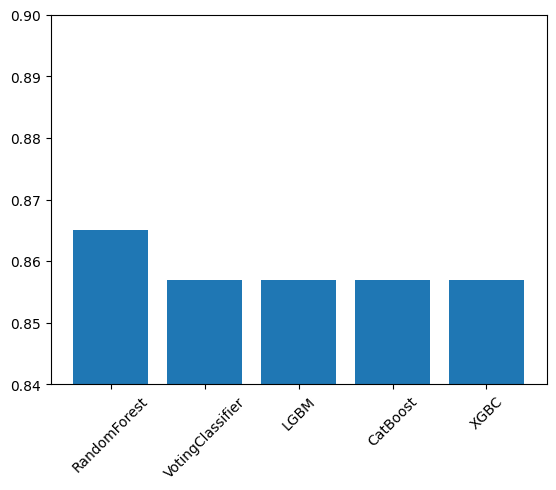

In [444]:
plt.bar(results_df["Classifier"], results_df["Accuracy"])
plt.ylim(0.84, 0.9)
plt.xticks(rotation=45)
;

In [6]:
import joblib

joblib.dump(rf_pipe, "./Streamlit/rf_pipe.pkl")

['./Streamlit/rf_pipe.pkl']

5. Выберете лучшую модель и попробуйте задеплоить ее в Streamlit.

* Создайте просто интерфейс для пользователя, куда бы он мог ввести необходимые данные, а вы бы ему вернули предсказание